# Starting

Run the following code to import the modules and download all the files you'll need.. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [39]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy
from google.colab.patches import cv2_imshow
from skimage import segmentation
from skimage import io, color
import skimage


In [40]:
! wget -O img1.bmp "https://drive.google.com/uc?export=download&id=1SpWUZ_0TJ5_K3_u6ZXFwyLDoWVl1wUUo"
! wget -O img2.bmp "https://drive.google.com/uc?export=download&id=1AoR9Od6vJQLYpoDGoh5hEye5-17_p7uC"
! wget -O fhat.png "https://drive.google.com/uc?export=download&id=1Z3w2tZCZLmzD2sSFn063sIaDewaAc7e3"
! wget -O f.png "https://drive.google.com/uc?export=download&id=1TZ41TXhtkIQ-t4pa0dP6z-TxwhTpHIgc"
! wget -O flower.jpg "https://drive.google.com/uc?export=download&id=1qCHktGU-wPJgIgeSGm7Pfe5mFraXk6R5"
! wget -O veggies.jpg "https://drive.google.com/uc?export=download&id=1O5tGFZ5hwPSACK8KJ5S5ULc6ufAMNR7d"
! wget -O porch.jpg "https://drive.google.com/uc?export=download&id=1aRU15CHkEPlUsnUvRFzpb7cWaoxBdQ_2"

--2020-12-06 01:43:15--  https://drive.google.com/uc?export=download&id=1SpWUZ_0TJ5_K3_u6ZXFwyLDoWVl1wUUo
Resolving drive.google.com (drive.google.com)... 173.194.215.139, 173.194.215.102, 173.194.215.113, ...
Connecting to drive.google.com (drive.google.com)|173.194.215.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d65n4gn7g7ktmji974mn73vt3t461tpb/1607218950000/14000179195872343522/*/1SpWUZ_0TJ5_K3_u6ZXFwyLDoWVl1wUUo?e=download [following]
--2020-12-06 01:43:16--  https://doc-0g-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d65n4gn7g7ktmji974mn73vt3t461tpb/1607218950000/14000179195872343522/*/1SpWUZ_0TJ5_K3_u6ZXFwyLDoWVl1wUUo?e=download
Resolving doc-0g-bo-docs.googleusercontent.com (doc-0g-bo-docs.googleusercontent.com)... 173.194.214.132, 2607:f8b0:400c:c0b::84
Connecting to doc-0g-bo-docs.googleusercontent.com (d

#Visualizing the images

You will use img1 and img2 to test your potts model implementation.

In [41]:
def potts(img, beta=1):
  """function that takes an image and  the hyperparameter beta as inputs and
  return a scalar E representing the potts energy oif the image"""
  E = None
  # ===============================================
  # TODO: replace pass with your code
  E = 0
  for x in range(len(img)):
    for y in range(len(img[x])-1):
      if img[x][y] != img[x][y+1]:
        E = E + beta

  for x in range(len(img)-1):
    for y in range(len(img[x])):
      if img[x][y] != img[x+1][y]:
        E = E + beta
  # ===============================================
  return E

#Visualizing the images

For this problem we will be working with an image of some vegetables, a porch and a flag.

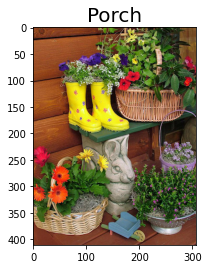

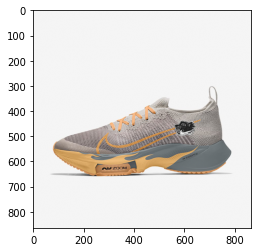

(864, 864, 3)


In [42]:

porch = plt.imread('porch.jpg')/255
porch = porch[:,:,:3]
plt.title("Porch", fontsize=20)
plt.imshow(porch)
plt.show()

shoes = plt.imread('left.jpg')/255
shoes = shoes[:,:,:3]
plt.imshow(shoes)
plt.show()
print(shoes.shape)

# Creating the superpixel maps

The code below will make superpixel maps of our three images. We use the skimage implementation of the SLIC superpixel algorithm. Here is a great medium article explaining how the algorithm works: https://medium.com/@darshita1405/superpixels-and-slic-6b2d8a6e4f08. This algorithm generates superpixels by clustering pixels based on their color similarity and proximity in the image plane. We provide a lot of functions for you. The output of the slic function is a label map (every segment has a differnt number assigned to it). 

For visualization purposed we use the function label2rgb to convert this map to a 3-channel image where every label is assigned a color. We also use the function apply_supermap to assign the color of the cluster centers to every pixel of their corresponding segmentation groups.

In [43]:
def label2rgb(labels):
  """
  Convert a labels image to an rgb image using a matplotlib colormap
  """
  label_range = np.linspace(0, 1, 256)
  lut = np.uint8(plt.cm.viridis(label_range)[:,2::-1]*256).reshape(256, 1, 3) # replace viridis with a matplotlib colormap of your choice
  return cv2.LUT(cv2.merge((labels, labels, labels)), lut)

In [44]:
def cluster_centers(superpixel_map):
  """ This function takes a superpixel map and returns a list with the 
  (row,col) positions of the cluster centers for that map"""

  x_centers = np.zeros(len(np.unique(superpixel_map)))
  y_centers = np.zeros_like(x_centers)
  counts = np.zeros_like(x_centers)
  rows, cols = superpixel_map.shape

  for row in range(rows):
    for col in range(cols):
      x_centers[superpixel_map[row, col]] += col
      y_centers[superpixel_map[row, col]] += row
      counts[superpixel_map[row, col]] += 1

  x_centers = np.round(x_centers/counts).astype('int')
  y_centers = np.round(y_centers/counts).astype('int')
  centers = list(zip(y_centers, x_centers))


  return centers

In [45]:
def apply_supermap(img, superpixel_map):
  """ This function returns an image where we assign the color of the cluster centers 
  to every pixel of their corresponding segmentation groups."""
  centers = cluster_centers(superpixel_map)
  out = np.zeros_like(img)
  for i,(row, col) in enumerate(centers):
    if img[row,col,0] == img[row,col,1] and img[row,col,1] == img[row,col,2] and img[row,col,2] > 0.9 :
      out[superpixel_map == i] = [1,1,1]
    else:
      out[superpixel_map == i] = [0,0,0]
  return out
  

#Visualizing SLIC superpixel maps

(864, 864, 3)
(864, 864)
(864, 864, 3)


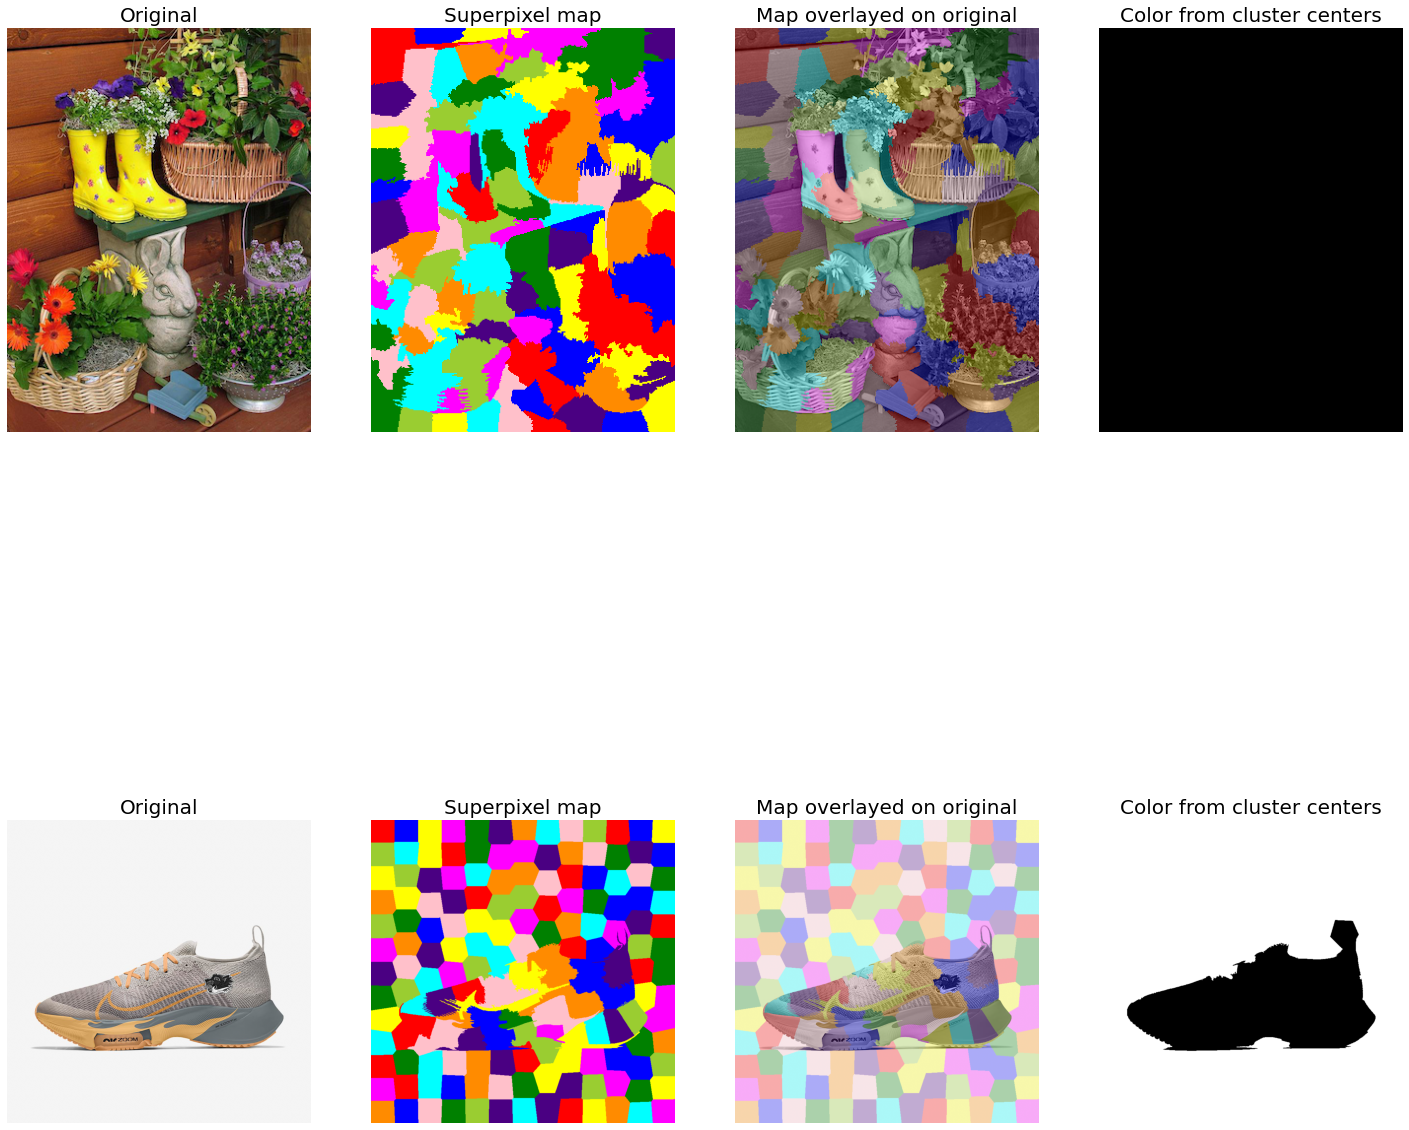

In [46]:


super_porch = segmentation.slic(porch, n_segments=144, compactness=20, max_iter=20)


super_shoes = segmentation.slic(shoes, n_segments=165, compactness=25, max_iter=20)


fig, ax = plt.subplots(2, 4, figsize=(25,25))
images = [porch, shoes]
maps = [super_porch, super_shoes]
shoes_b = apply_supermap(shoes, super_shoes)
for i,a in enumerate(ax):
  a[0].set_axis_off()
  a[0].set_title('Original', fontsize=20)
  a[0].imshow(images[i])
  a[1].set_axis_off()
  a[1].set_title('Superpixel map', fontsize=20)
  a[1].imshow(skimage.color.label2rgb(maps[i]))
  a[2].set_axis_off()
  a[2].set_title('Map overlayed on original', fontsize=20)
  a[2].imshow(skimage.color.label2rgb(maps[i], images[i]))
  a[3].set_axis_off()
  a[3].set_title('Color from cluster centers', fontsize=20)
  a[3].imshow(apply_supermap(images[i], maps[i]))

print(apply_supermap(images[i], maps[i]).shape)
print(super_shoes.shape)
print(shoes.shape)

#Implement color histogram

You will implement the function color_histogram next. This function takes an image, a binary mask and the number of bins that you want to use for every channel. The function will compute the histogram over the 1 values in the mask only. 

In [47]:
def color_histogram(img, mask, num_bins):
  """For each channel in the image, compute a color histogram with the number of bins
  given by num_bins of the pixels in 
  image where the mask is true. Then, concatenate the vectors together into one column vector (first
  channel at top).

  Mask is a matrix of booleans the same size as image.
 
  You MUST normalize the histogram of EACH CHANNEL so that it sums to 1.
  You CAN use the numpy.histogram function.
  You MAY loop over the channels.
  The output should be a 3*num_bins vector because we have a color image and 
  you have a separate histogram per color channel.
  
  Hint: np.histogram(img[:,:,channel][mask], num_bins)"""

  rows, cols, channels = img.shape
  histogram = np.zeros(num_bins*3)

  # ===============================================
  # TODO: replace pass with your code
  channel1 = np.histogram(img[:,:,0][mask], num_bins)[0]
  channel2 = np.histogram(img[:,:,1][mask], num_bins)[0]
  channel3 = np.histogram(img[:,:,2][mask], num_bins)[0]
  
  channel1 = channel1/np.sum(channel1)
  channel2 = channel2/np.sum(channel2)
  channel3 = channel3/np.sum(channel3)

  histogram = np.concatenate((channel1, channel2, channel3))
  # ===============================================
  return histogram
  


#Implement adjacency matrix

You need to implement the adjacency matrix function that takes a superpixel map as an input and outputs a binary adjacency matrix.

In [48]:
def adjacencyMatrix(superpixel_map):
  """Implement the code to compute the adjacency matrix for the superpixel map
  The input is a superpixel map and the output is a binary adjacency matrix NxN 
  (N being the number of superpixelsin svMap).  Bmap has a 1 in cell i,j if 
  superpixel i and j are neighbors. Otherwise, it has a 0.  Superpixels are neighbors 
  if any of their pixels are neighbors."""

  segmentList = np.unique(superpixel_map)
  segmentNum = len(segmentList)
  adjMatrix = np.zeros((segmentNum, segmentNum))

  # ===============================================
  # TODO: replace pass with your code
  for x in range(len(superpixel_map)):
    for y in range(len(superpixel_map[x])-1):
      i = superpixel_map[x][y]
      j = superpixel_map[x][y+1]
      if i != j:
        adjMatrix[i][j] = 1
        adjMatrix[j][i] = 1

  for x in range(len(superpixel_map)-1):
    for y in range(len(superpixel_map[x])):
      i = superpixel_map[x][y]
      j = superpixel_map[x+1][y]
      if i != j:
        adjMatrix[i][j] = 1
        adjMatrix[j][i] = 1

  # ===============================================

  return adjMatrix

#Visualize your implementation

The following code will show the adjacency matrices for the 4 images. 

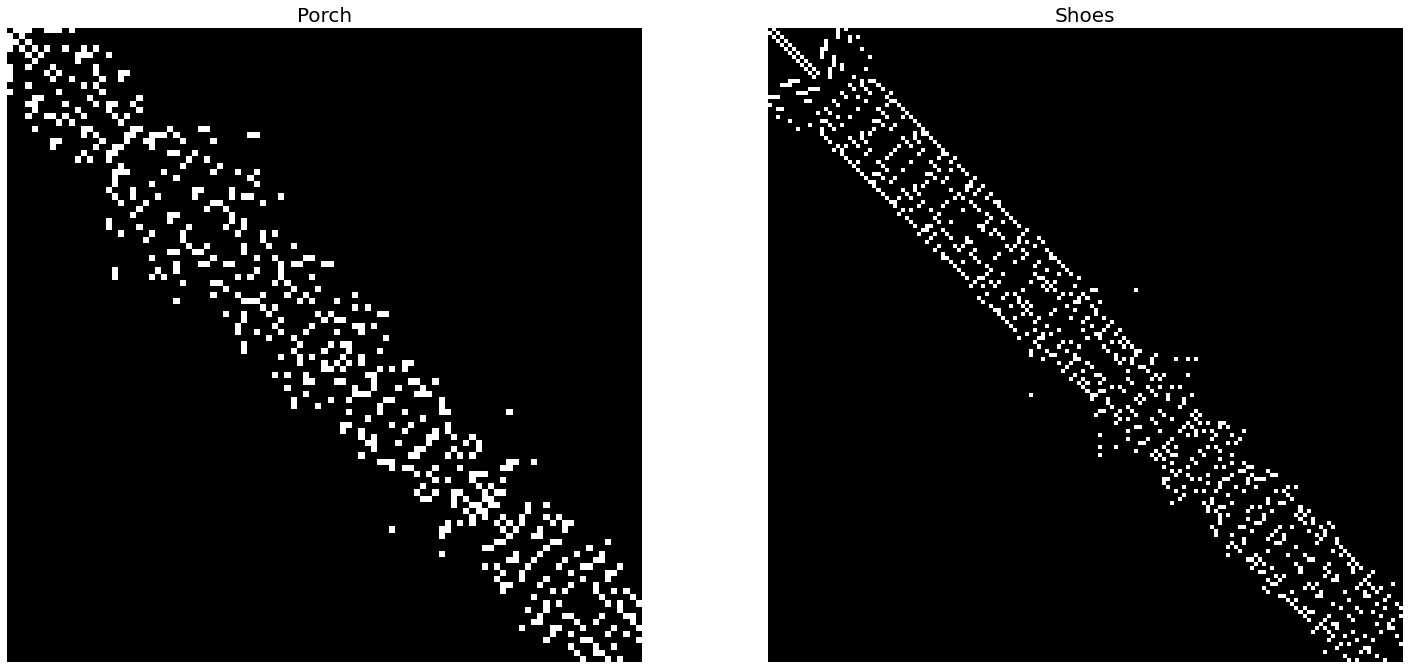

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(25,25))
images = [porch, shoes_b]
maps = [super_porch, super_shoes]

adjMatrix_porch = adjacencyMatrix(super_porch)
adjMatrix_shoes = adjacencyMatrix(super_shoes)

ax[0].set_axis_off()
ax[0].set_title('Porch', fontsize=20)
ax[0].imshow(adjMatrix_porch, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title('Shoes', fontsize=20)
ax[1].imshow(adjMatrix_shoes, cmap="gray")






# Calculate average node degree

You will implement a function that takes an adjacency matrix as input and outputs the average node degree. This is the average number of neighborghs that segments have.

In [50]:
def average_node_degree(adjMatrix):
  """ This function takes an adjacency matrix and returns 
  the average number of neighborghs that the segments have 
  (average node degree)"""

  # ===============================================
  # TODO: replace pass with your code
  average_node_degree= adjMatrix.sum()/len(adjMatrix)
  # ===============================================
  
  return average_node_degree

#Implement your graph-cut algorithm

It is time to build your foreground-background segmentation algorithm. For this we provide you with the implementation of the Ford-fulkerson algorithm which you will need to determine where your graph should be cut. You can learn more about the algorithm here: https://www.geeksforgeeks.org/ford-fulkerson-algorithm-for-maximum-flow-problem/. Please note that our version of the Ford Fulkerson algorithm doesn't return the max flow as a scalar. It returns the current flow through each edge of the graph when we reach the point of maximum flow.

We also implemented the reduce function which takes an image, its corresponding superpixel map, and a number of bins as input. The output is a list of feature vectors. Each feature vector is the resulting histogram from applying the color_histogram function you implemented to every segment on the superpixel map.

You will implement the graph_cut function 


In [51]:
# Python program for implementation of Ford Fulkerson algorithm 
# The author of this code is Neelam Yadav 

from collections import defaultdict 
   
#This class represents a directed graph using adjacency matrix representation 
class Graph: 
   
    def __init__(self,graph): 
        self.graph = graph # residual graph 
        self. ROW = len(graph) 
        # self.COL = len(gr[0]) 
          
   
    '''Returns true if there is a path from source 's' to sink 't' in 
    residual graph. Also fills parent[] to store the path '''
    def BFS(self,s, t, parent): 
  
        # Mark all the vertices as not visited 
        visited =[False]*(self.ROW) 
          
        # Create a queue for BFS 
        queue=[] 
          
        # Mark the source node as visited and enqueue it 
        queue.append(s) 
        visited[s] = True
           
         # Standard BFS Loop 
        while queue: 
  
            #Dequeue a vertex from queue and print it 
            u = queue.pop(0) 
          
            # Get all adjacent vertices of the dequeued vertex u 
            # If a adjacent has not been visited, then mark it 
            # visited and enqueue it 
            for ind, val in enumerate(self.graph[u]): 
                if visited[ind] == False and val > 0 : 
                    queue.append(ind) 
                    visited[ind] = True
                    parent[ind] = u 
  
        # If we reached sink in BFS starting from source, then return 
        # true, else false 
        return True if visited[t] else False
              
      
    # Returns tne current flow from s to t in the given graph 
    def FordFulkerson(self, source, sink): 
  
        # This array is filled by BFS and to store path 
        parent = [-1]*(self.ROW) 
  
        max_flow = 0 # There is no flow initially 
        current_flow = np.zeros_like(self.graph)
  
        # Augment the flow while there is path from source to sink 
        while self.BFS(source, sink, parent) : 
            # Find minimum residual capacity of the edges along the 
            # path filled by BFS. Or we can say find the maximum flow 
            # through the path found. 
            path_flow = float("Inf") 
            s = sink 
            while(s !=  source): 
                path_flow = min (path_flow, self.graph[parent[s]][s]) 
                s = parent[s] 
  
            # Add path flow to overall flow 
            max_flow +=  path_flow 
  
            # update residual capacities of the edges and reverse edges 
            # along the path 
            v = sink 
            while(v !=  source): 
                u = parent[v] 
                self.graph[u][v] -= path_flow 
                self.graph[v][u] += path_flow 
                current_flow[u][v] += path_flow 
                current_flow[v][u] -= path_flow 
                v = parent[v] 
        
        return current_flow
  

In [52]:
def reduce(img, superpixel_map, num_bins=10):
  """This function takes as input an image, its corresponding superpixel map, and a 
  number of bins as input. The output is a list of feature vectors. 
  Each feature vector is the resulting histogram from applying the color_histogram 
  function you implemented to every segment on the superpixel map."""

  feature_vectors = []
  num_segments = len(np.unique(superpixel_map))
  for i in range(num_segments):
      mask = superpixel_map == i
      feature_vectors.append(color_histogram(img, mask, num_bins))
  return(feature_vectors)

In [60]:
def graph_cut(superpixel_map, features, centers, keyindex):
  """Function to take a superpixel set and a keyindex and convert to a 
  foreground/background segmentation.
  
  keyindex is the index to the superpixel segment we wish to use as foreground and
  find its relevant neighbors.
  
  centers is a list of tuples (row, col) with the positions of the cluster centers 
  of the superpixel_map

  features is a list of histograms (obtained from the reduce function) for every superpixel
  segment in an image.
  
  """

  #Compute basic adjacency information of superpixels
  #Note that adjacencyMatrix is code you need to implement

  # ===============================================
  # TODO: this should be one line of code

  adjMatrix = adjacencyMatrix(superpixel_map);

  # ===============================================
  

  # normalization for distance calculation based on the image size
  # for points (x1,y1) and (x2,y2), distance is
  # exp(-||(x1,y1)-(x2,y2)||^2/dnorm)
  dnorm = 2*(superpixel_map.shape[0]/2 *superpixel_map.shape[1] /2)**2
  k = len(features) #number of superpixels in image

  #Generate capacity matrix
  capacity = np.zeros((k+2,k+2))
  source = k
  sink = k+1

  # This is a single planar graph with an extra source and sink
  #  Capacity of a present edge in the graph is to be defined as the product of
  #  1:  the histogram similarity between the two color histogram feature vectors.
  #  The similarity between histograms should be computed as the intersections between 
  #  the histograms. i.e: sum(min(histogram 1, histogram 2))
  #  2:  the spatial proximity between the two superpixels connected by the edge.
  #      use exp(-||(x1,y1)-(x2,y2)||^2/dnorm) 
  #      
  #  Source gets connected to every node except sink
  #  Capacity is with respect to the keyindex superpixel
  #  Sink gets connected to every node except source and its capacity is opposite 
  # The weight between a pixel and the sink is going to be the max of all the weights between 
  # the source and the image pixels minus the weight between that specific pixel and the source.
  # Other superpixels get connected to each other based on computed adjacency
  # matrix: the capacity is defined as above, EXCEPT THAT YOU ALSO NEED TO MULTIPLY BY A SCALAR 0.25 for
  # adjacent superpixels.


  key_features = features[keyindex] # color histogram representation of superpixel # keyindex
  key_x = centers[keyindex][1] # row of cluster center for superpixel # keyindex
  key_y = centers[keyindex][0] # col of cluster center for superpixel # keyindex

  # ===============================================
  # TODO: Generate the capacity matrix using the description above. Replace pass with your code
  import math 
  for i in range(k):
    for j in range(k):
      if adjMatrix[i][j] == 1:
        if np.count_nonzero(features[i]) == 3 or np.count_nonzero(features[j]) == 3:
          similarity = 0
        else:
          similarity = np.sum(np.minimum(features[i], features[j]))
        proximity =  math.exp(-((centers[i][0] - centers[j][0])**2 + (centers[i][1] - centers[j][1])**2)/dnorm)
        capacity[i][j] = similarity * proximity * 0.25
  
  max = 0
  for x in range(k):
    if np.count_nonzero(features[x]) == 3:
      similarity = 0
    else:
      similarity = np.sum(np.minimum(features[x],key_features))
    proximity =  math.exp(-((centers[x][0] - key_y)**2 + (centers[x][1] - key_x)**2)/dnorm)
    capacity[k][x] = similarity * proximity
    if max < capacity[k][x]:
      max = capacity[k][x]
  
  for y in range(k):
    capacity[y][k+1] = max - capacity[k][y]
  # ===============================================
      
  # Obtaining the current flow of the graph when the flow is max
  g = Graph(capacity.copy()) 
  current_flow = g.FordFulkerson(source, sink)
  
  # Extract the two-class segmentation.
  # the cut will separate all nodes into those connected to the
  # source and those connected to the sink.
  # The current_flow matrix contains the necessary information about
  # the max-flow through the graph.
  
  segment_map = np.zeros_like(superpixel_map)
  rem_capacity = capacity - current_flow

  # ===============================================
  # TODO: Do the segmentation and fill segmentation map with 1s where the foreground is.
  # Replace pass with your code
  def BFS_edit(cap,s): 
  
        # Mark all the vertices as not visited 
        visited =[False]*(len(cap)) 
          
        # Create a queue for BFS 
        queue=[] 
          
        # Mark the source node as visited and enqueue it 
        queue.append(s) 
        visited[s] = True
           
         # Standard BFS Loop 
        while queue: 
  
            #Dequeue a vertex from queue and print it 
            u = queue.pop(0) 
          
            # Get all adjacent vertices of the dequeued vertex u 
            # If a adjacent has not been visited, then mark it 
            # visited and enqueue it 
            for ind, val in enumerate(cap[u]): 
                if visited[ind] == False and val > 0 : 
                    queue.append(ind) 
                    visited[ind] = True
  
        # If we reached sink in BFS starting from source, then return 
        # true, else false 
        return visited


  visited = BFS_edit(rem_capacity,source)
  for x in range(len(segment_map)):
    for y in range(len(segment_map[x])):
      node = superpixel_map[x][y]
      if visited[node]:
        segment_map[x][y] = 1

  # ===============================================

  return capacity, segment_map
 

#Visualize capacity matrix

3
82


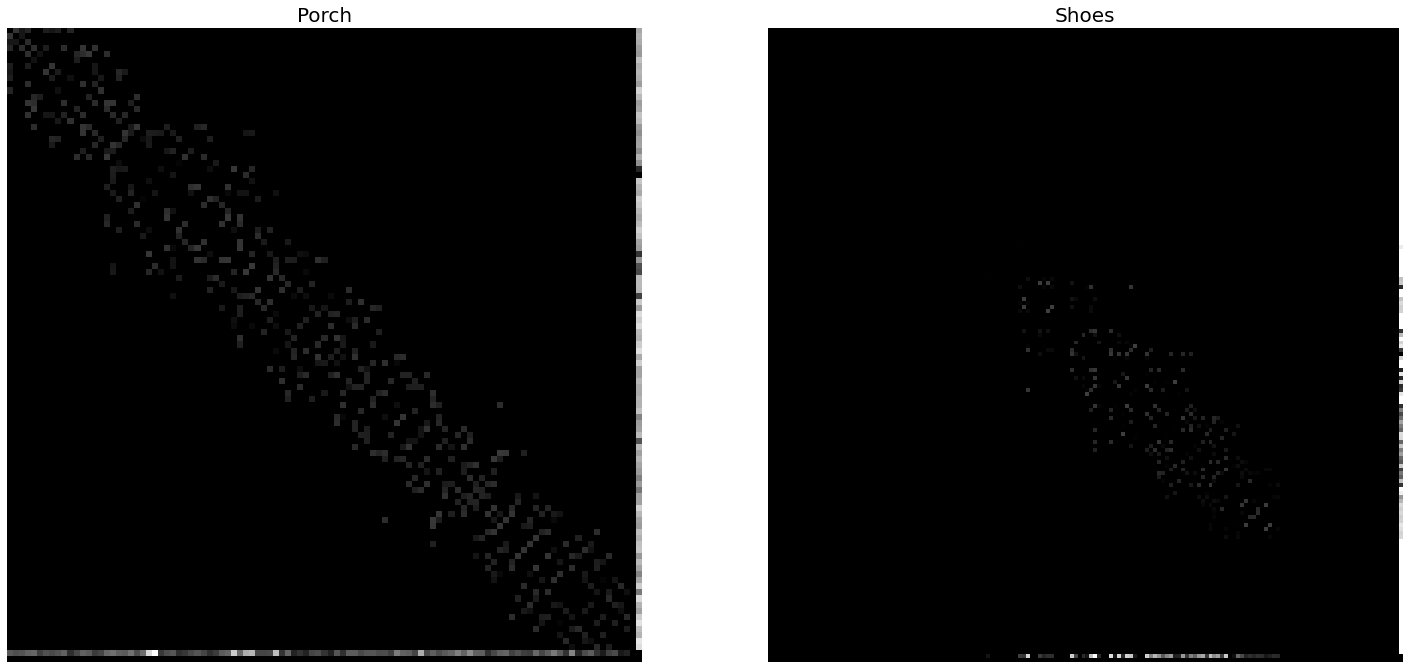

In [62]:
porch_features = reduce(porch, super_porch)
porch_centers = cluster_centers(super_porch)
porch_capacity,porch_segment_map = graph_cut(super_porch, porch_features, porch_centers, 24)

shoes_features = reduce(shoes, super_shoes)
shoes_centers = cluster_centers(super_shoes)
shoes_capacity,shoes_segment_map = graph_cut(super_shoes, shoes_features, shoes_centers, 82)
print(np.count_nonzero(shoes_features[1]))
print(super_shoes[432,432])


fig, ax = plt.subplots(1, 2, figsize=(25,25))
ax[0].set_axis_off()
ax[0].set_title('Porch', fontsize=20)
ax[0].imshow(porch_capacity, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title('Shoes', fontsize=20)
ax[1].imshow(shoes_capacity, cmap="gray")
ax[1].set_axis_off()




#Visualizing graphcut segmentation

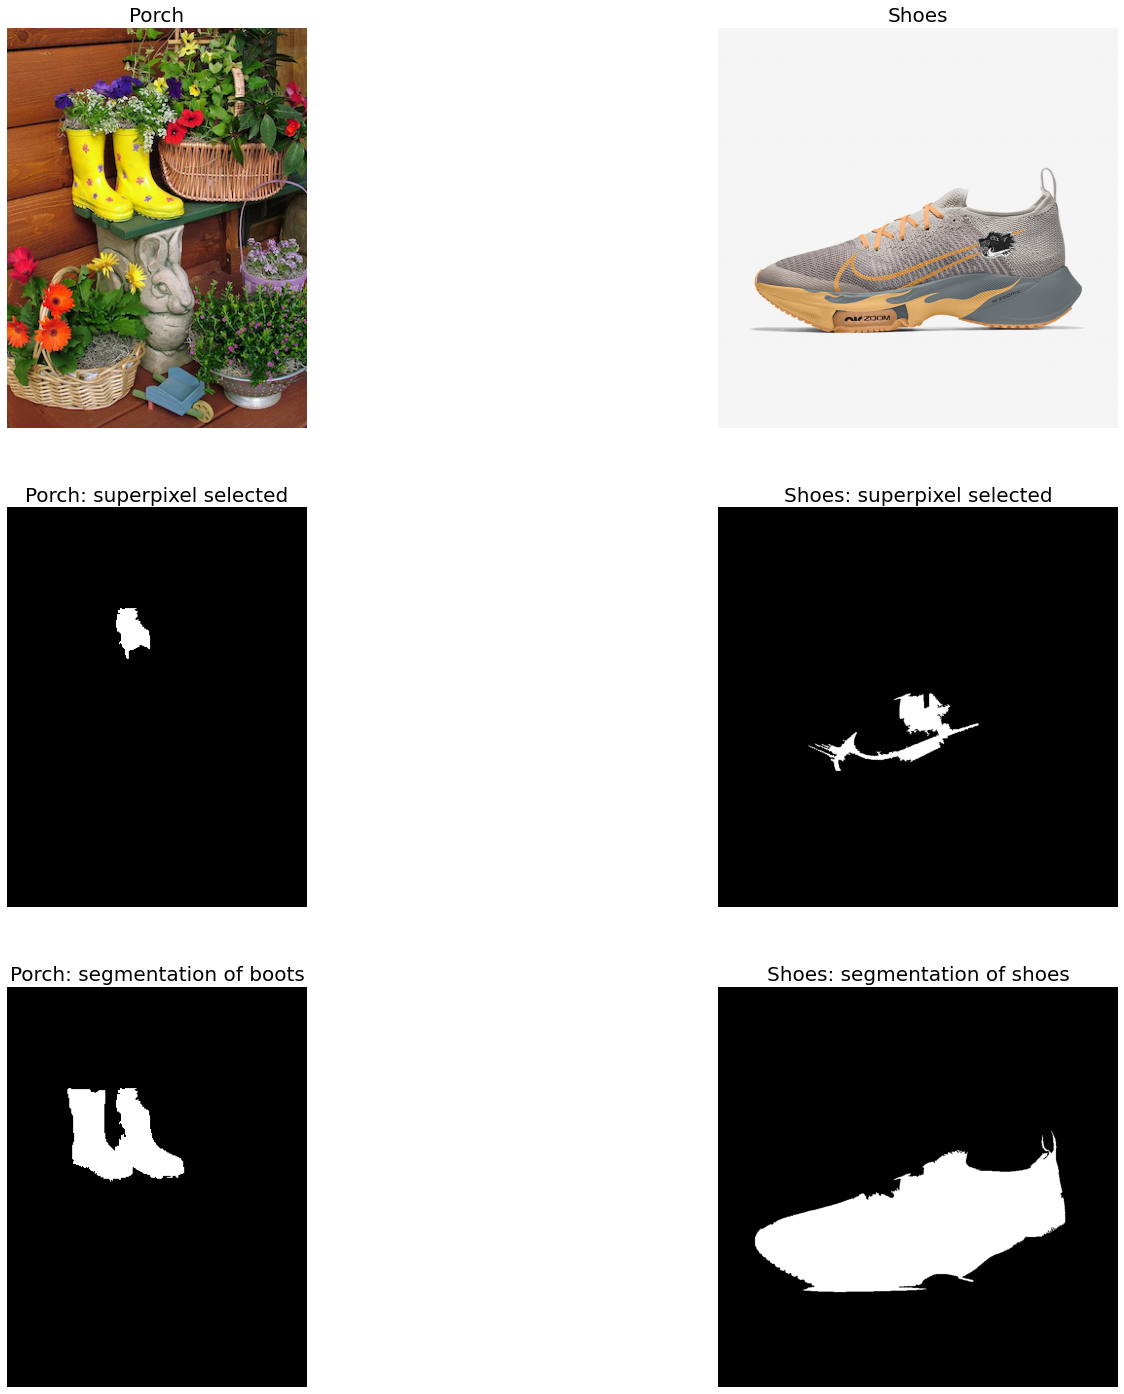

In [63]:
fig, ax = plt.subplots(3, 2, figsize=(25,25))


ax[0][0].set_axis_off()
ax[0][0].set_title('Porch', fontsize=20)
ax[0][0].imshow(porch, cmap="gray")
ax[0][1].set_axis_off()
ax[0][1].set_title('Shoes', fontsize=20)
ax[0][1].imshow(shoes, cmap="gray")
ax[0][1].set_axis_off()

ax[1][0].set_axis_off()
ax[1][0].set_title('Porch: superpixel selected', fontsize=20)
ax[1][0].imshow(super_porch==24, cmap="gray")
ax[1][1].set_axis_off()
ax[1][1].set_title('Shoes: superpixel selected', fontsize=20)
ax[1][1].imshow(super_shoes==82, cmap="gray")
ax[1][1].set_axis_off()



ax[2][0].set_axis_off()
ax[2][0].set_title('Porch: segmentation of boots', fontsize=20)
ax[2][0].imshow(porch_segment_map, cmap="gray")
ax[2][1].set_axis_off()
ax[2][1].set_title('Shoes: segmentation of shoes', fontsize=20)
ax[2][1].imshow(shoes_segment_map, cmap="gray")
ax[2][1].set_axis_off()

